In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
from torch.utils.data import DataLoader, random_split
from transformers import ViTModel,ViTForImageClassification, ViTConfig
from tqdm import tqdm

/media/mldadmin/home/s123mdg34_04/anaconda3/envs/FYP/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Dataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): CSV文件的路径，包含文件名和标签。
            img_dir (string): 图片文件的目录。
            transform (callable, optional): 可选的转换操作，应用于图片。
        """
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label
    
def create_dataloader(csv_file, img_dir, batch_size, transform, val_split=0.25):
    dataset = Dataset(csv_file=csv_file, img_dir=img_dir, transform=transform)
    
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    
    # 随机分割数据集
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    # 创建训练集和验证集的DataLoader
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataloader, val_dataloader

In [3]:
# 你可以根据需要修改下面的转换操作
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.GaussianBlur(kernel_size=(15, 15)),
    transforms.ColorJitter(brightness=0.2, contrast=0.3 , saturation = 0.2, hue=0.3), #random brightness, contrast etc
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), # ImageNet prior
])

In [4]:
csv_file = './data/train.csv'
img_dir = './data/train/train_images/'
batch_size = 128

In [5]:
train_loader, val_loader = create_dataloader(csv_file, img_dir, batch_size, transform)

# 用一个循环来查看数据
for images, labels in train_loader:
    print(images.shape, labels)
    break

# label
# 3    13158
# 4     2577
# 2     2386
# 1     2189
# 0     1087

torch.Size([128, 3, 224, 224]) tensor([3, 4, 3, 3, 2, 4, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 2, 3,
        2, 3, 3, 4, 4, 3, 2, 3, 3, 4, 3, 3, 3, 0, 1, 3, 3, 2, 3, 3, 1, 3, 3, 1,
        3, 3, 3, 3, 3, 3, 4, 3, 3, 1, 3, 1, 3, 3, 3, 3, 4, 2, 1, 3, 3, 3, 3, 4,
        4, 1, 3, 3, 3, 3, 3, 3, 3, 1, 2, 3, 4, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 0, 0, 3, 4, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 4, 4, 0, 3, 3, 2, 3, 3, 3,
        1, 3, 2, 3, 3, 3, 3, 3])


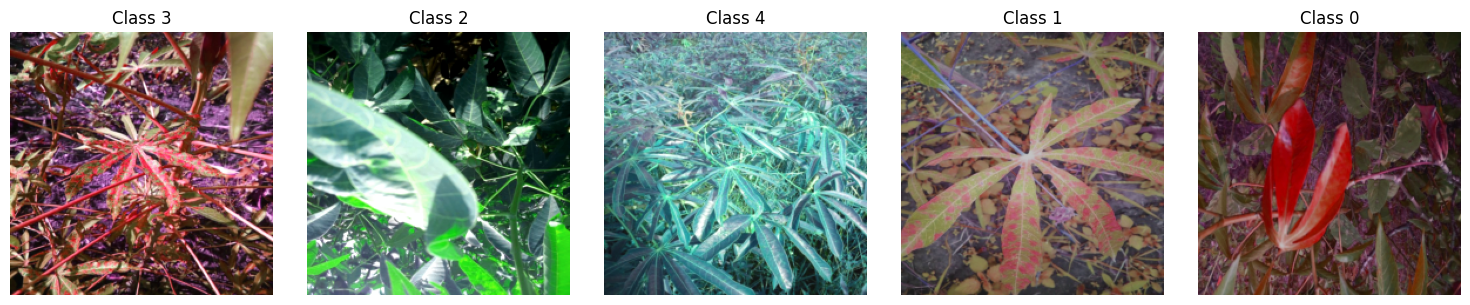

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, ax):
    # 将Tensor图像转换为NumPy，进行反标准化
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # 反标准化
    img = np.clip(img, 0, 1)  # 将图像剪切到0-1之间
    ax.imshow(img)
    ax.axis('off')  # 隐藏坐标轴

# 获取一批数据
images, labels = next(iter(train_loader))

# 记录已选择的类别
selected_classes = set()

# 存储每个类别的第一个图像
class_images = {}

for i, label in enumerate(labels):
    label = label.item()
    if label not in selected_classes:
        # 把该类别的图像添加到字典中
        class_images[label] = images[i]
        selected_classes.add(label)
    if len(class_images) == len(set(labels.tolist())):  # 如果我们已经选出了每个类别的图像
        break

# 确保我们有一个轴用于每个类别的图像
fig, axes = plt.subplots(1, len(class_images), figsize=(15, 3))
axes = axes.flatten() if len(class_images) > 1 else [axes]  # 确保axes是列表

# 绘制每个类别的图像
for ax, (cls, img) in zip(axes, class_images.items()):
    ax.set_title(f'Class {cls}')
    imshow(img, ax)

plt.tight_layout()
plt.show()


In [7]:
configuration = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')
ViT_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', config=configuration)
ViT_model.classifier = nn.Linear(ViT_model.config.hidden_size, 5)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
ViT_model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [10]:

def ViT_train_model(model, criterion, optimizer, num_epochs=10):
    model = model.to(device)
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # 将tqdm应用于训练数据加载器
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs.logits, 1)
                loss = criterion(outputs.logits, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.cpu().numpy())
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
        
        # 验证过程
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in tqdm(val_loader, desc=f'Validation {epoch+1}/{num_epochs}', unit='batch'):
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs.logits, 1)
                loss = criterion(outputs.logits, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        history['val_loss'].append(epoch_loss)
        history['val_acc'].append(epoch_acc.cpu().numpy())
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_loss:.4f}, Validation Acc: {epoch_acc:.4f}')

    return history

In [11]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1/1087, 1/2189, 1/2386, 1/2577, 1/13158]).to(device))
optimizer = torch.optim.Adam(ViT_model.parameters(), lr=0.0001)

history = ViT_train_model(ViT_model, criterion, optimizer, num_epochs=10)
torch.save(ViT_model.state_dict(), './model/ViT_model.pth')

Epoch 1/10:   0%|          | 0/126 [00:00<?, ?batch/s]

Epoch 1/10: 100%|██████████| 126/126 [04:15<00:00,  2.03s/batch]


Epoch 1/10, Train Loss: 0.7450, Train Acc: 0.6943


Validation 1/10: 100%|██████████| 42/42 [00:59<00:00,  1.43s/batch]


Epoch 1/10, Validation Loss: 0.5337, Validation Acc: 0.7431


Epoch 2/10: 100%|██████████| 126/126 [04:03<00:00,  1.93s/batch]


Epoch 2/10, Train Loss: 0.5086, Train Acc: 0.7613


Validation 2/10: 100%|██████████| 42/42 [00:54<00:00,  1.29s/batch]


Epoch 2/10, Validation Loss: 0.4781, Validation Acc: 0.7766


Epoch 3/10: 100%|██████████| 126/126 [04:01<00:00,  1.92s/batch]


Epoch 3/10, Train Loss: 0.4217, Train Acc: 0.7970


Validation 3/10: 100%|██████████| 42/42 [00:53<00:00,  1.28s/batch]


Epoch 3/10, Validation Loss: 0.4415, Validation Acc: 0.7800


Epoch 4/10: 100%|██████████| 126/126 [04:00<00:00,  1.91s/batch]


Epoch 4/10, Train Loss: 0.3840, Train Acc: 0.8116


Validation 4/10: 100%|██████████| 42/42 [00:53<00:00,  1.28s/batch]


Epoch 4/10, Validation Loss: 0.4662, Validation Acc: 0.7966


Epoch 5/10: 100%|██████████| 126/126 [04:02<00:00,  1.93s/batch]


Epoch 5/10, Train Loss: 0.3439, Train Acc: 0.8266


Validation 5/10: 100%|██████████| 42/42 [00:53<00:00,  1.27s/batch]


Epoch 5/10, Validation Loss: 0.4146, Validation Acc: 0.8011


Epoch 6/10: 100%|██████████| 126/126 [04:03<00:00,  1.93s/batch]


Epoch 6/10, Train Loss: 0.3059, Train Acc: 0.8389


Validation 6/10: 100%|██████████| 42/42 [00:53<00:00,  1.27s/batch]


Epoch 6/10, Validation Loss: 0.4228, Validation Acc: 0.7972


Epoch 7/10: 100%|██████████| 126/126 [04:02<00:00,  1.92s/batch]


Epoch 7/10, Train Loss: 0.2819, Train Acc: 0.8510


Validation 7/10: 100%|██████████| 42/42 [00:53<00:00,  1.27s/batch]


Epoch 7/10, Validation Loss: 0.5369, Validation Acc: 0.7615


Epoch 8/10: 100%|██████████| 126/126 [04:02<00:00,  1.92s/batch]


Epoch 8/10, Train Loss: 0.2559, Train Acc: 0.8573


Validation 8/10: 100%|██████████| 42/42 [00:53<00:00,  1.27s/batch]


Epoch 8/10, Validation Loss: 0.4410, Validation Acc: 0.8078


Epoch 9/10: 100%|██████████| 126/126 [04:02<00:00,  1.93s/batch]


Epoch 9/10, Train Loss: 0.2141, Train Acc: 0.8738


Validation 9/10: 100%|██████████| 42/42 [00:54<00:00,  1.30s/batch]


Epoch 9/10, Validation Loss: 0.4638, Validation Acc: 0.8104


Epoch 10/10: 100%|██████████| 126/126 [04:03<00:00,  1.93s/batch]


Epoch 10/10, Train Loss: 0.1983, Train Acc: 0.8807


Validation 10/10: 100%|██████████| 42/42 [00:54<00:00,  1.30s/batch]


Epoch 10/10, Validation Loss: 0.4658, Validation Acc: 0.8026


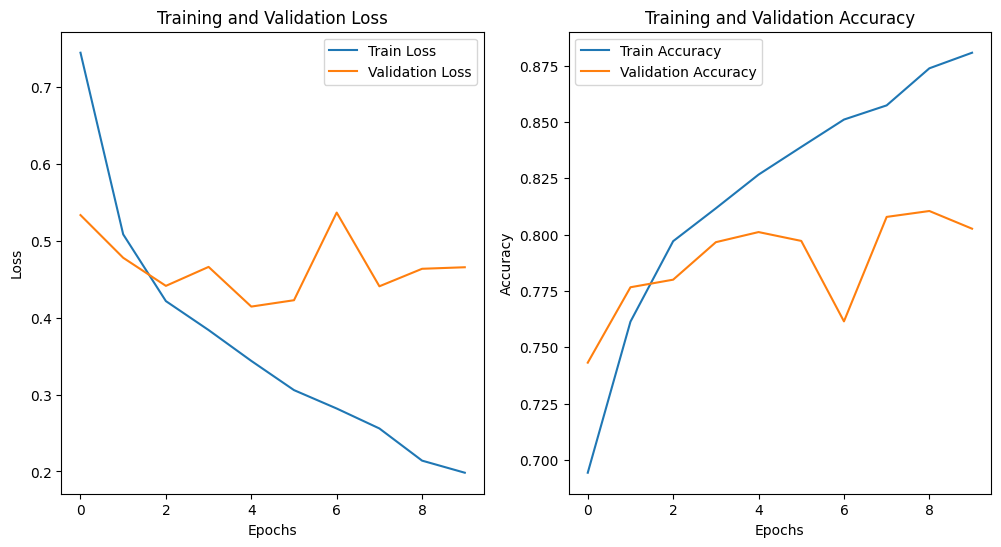

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [13]:
import tensorflow as tf

2024-04-22 16:32:31.251909: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 16:32:31.282205: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 16:32:34.834014: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
class ImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.filenames = [f for f in os.listdir(directory) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.directory, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        return image, img_name

In [15]:

# 定义图像转换操作
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整图像大小
    transforms.ToTensor(),          # 转换为tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 创建数据集实例
dataset = ImageDataset(directory='./data/test/test_images/', transform=transform)

# 创建 DataLoader
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

In [18]:
def test_model(model, test_loader):
    model.eval()
    results = []
    with torch.no_grad():
        for images, filenames in test_loader:
            images = images.to(device)
            outputs = model(images)
            predictions = torch.max(outputs.logits, 1)[1]  # 修改这里，使用输出中的 logits 属性
            
            for filename, prediction in zip(filenames, predictions):
                results.append([filename, prediction.item()])

    # 保存结果到 CSV
    import csv
    with open('submission.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['image_id', 'label'])
        writer.writerows(results)


In [19]:
# 调用测试函数
test_model(ViT_model, test_loader)